In [1]:
import torch
import matplotlib.pyplot as plt

Modelos Neuronales II
Autor: Jorge García González (Universidad de Málaga)

Última Actualización: 25/09/2025

Asignatura: Programación para la Inteligencia Artificial

Anteriormente hemos hablado de la neurona clásica, el papel de la función de activación en la misma y cómo una única neurona no tiene suficiente flexibilidad para ajustar funciones sencillas como y=x<sup>2</sup>. Vamos a hablar ahora de la combinación de varias neuronas. Vamos a hablar de las redes neuronales.

Antes, de nuevo vamos a rescatar algunas funciones del cuaderno anterior:

In [2]:
def generate_polynomial(c_list):
  """
  Función para generar una función que aplique un polinomio.
  Args:
    c_list: Lista de coeficientes del polinomio. ej: [2,1,0] representa el polinomio y = 2x**2 + x + 0
  """
  def apply_polynomial(x):
    """
    Función para aplicar un polinomio.
    Args:
      x: las entradas a las que aplicarle el polinomio.
    """
    y = torch.cat([c*x[None,:]**index for index, c in enumerate(reversed(c_list))]).sum(dim=0)  # Para cada coeficiente (desde el final) operamos todas
                                                                                                # las x elevándolo a su índice (0,1,2,etc) y obtenemos
                                                                                                # una fila.
                                                                                                # El cat concatena las filas, así cada columna tiene,
                                                                                                # para un solo x, las operaciones de cada término del
                                                                                                # polinomio.
                                                                                                # Finalmente sumamos a lo largo de las columnas.
    return y

  return apply_polynomial

def get_data_from_a_polynomial(poly, n, sigma=2, range=50):
  """
  Función que devuelve datos a partir de una recta. Recordemos que la ecuación de la recta está definida por y=mx+b.
  Args:
    poly: Función que aplica un polinomio.
    n: número de datos que queremos obtener.
    sigma: desviación típica para el ruido que añadiremos a los datos (2 por defecto).
    range: extremo del rango [0,rango] en el eje x en el que queremos situar los datos (50 por defecto).
  """
  x = range*torch.rand(n)                                                             # Generamos los datos en el eje x.
  y = poly(x)                                                                         # Obtenemos los valores del polinomio para cada x.
  noise_x = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y))               # Generamos un vector de ruido gaussiano para el eje x.
  noise_y = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y))               # Generamos un vector de ruido gaussiano para el eje y.
  x_with_noise = x + noise_x
  y_with_noise = y + noise_y

  data = torch.cat((x_with_noise[:,None], y_with_noise[:,None]), dim=1)
  return data

def draw_2D_function(function, range=[-4,4], function_label = None, title = None, data=None):
  plt.figure(figsize=(8,6))
  if data is not None:
    plt.scatter(data[:,0], data[:,1])
    x = torch.linspace(data[:,0].min(), data[:,0].max(), 100)
  else:
    x = torch.linspace(range[0], range[1], 100)
  y = function(x)
  plt.plot(x, y, label=function_label)

  if title is not None:
    plt.title(title)
  if function_label is not None:
    plt.legend()
  plt.grid(True)
  plt.show()

Una red neuronal es un grafo de neuronas. En teoría puede ser cualquier grafo de neuronas, pero en la práctica hay diversas estructuras habituales. Tipos de grafos concretos en combinación con ciertas neuronas y reglas de aprendizaje definen el tipo de red neuronal con el que se está trabajando.

Nosotros nos vamos a centrar en redes neuronales prealimentadas (feedforward neural networks). ¿Qué significa eso? Pues que nuestro grafo de neuronas es acíclico. Que no se retroalimenta en ningún momento.

Este tipo de redes es muy común y puede tener aspectos muy diversos. A continuación están los esquemas de la AlexNet (una red de clasificación de objetos), una red autocodificadora (comunmente llamadas por su nombre en ingles *autoencoder*) y la UNet (una red usada tanto en segmentación como en generación de imágenes).

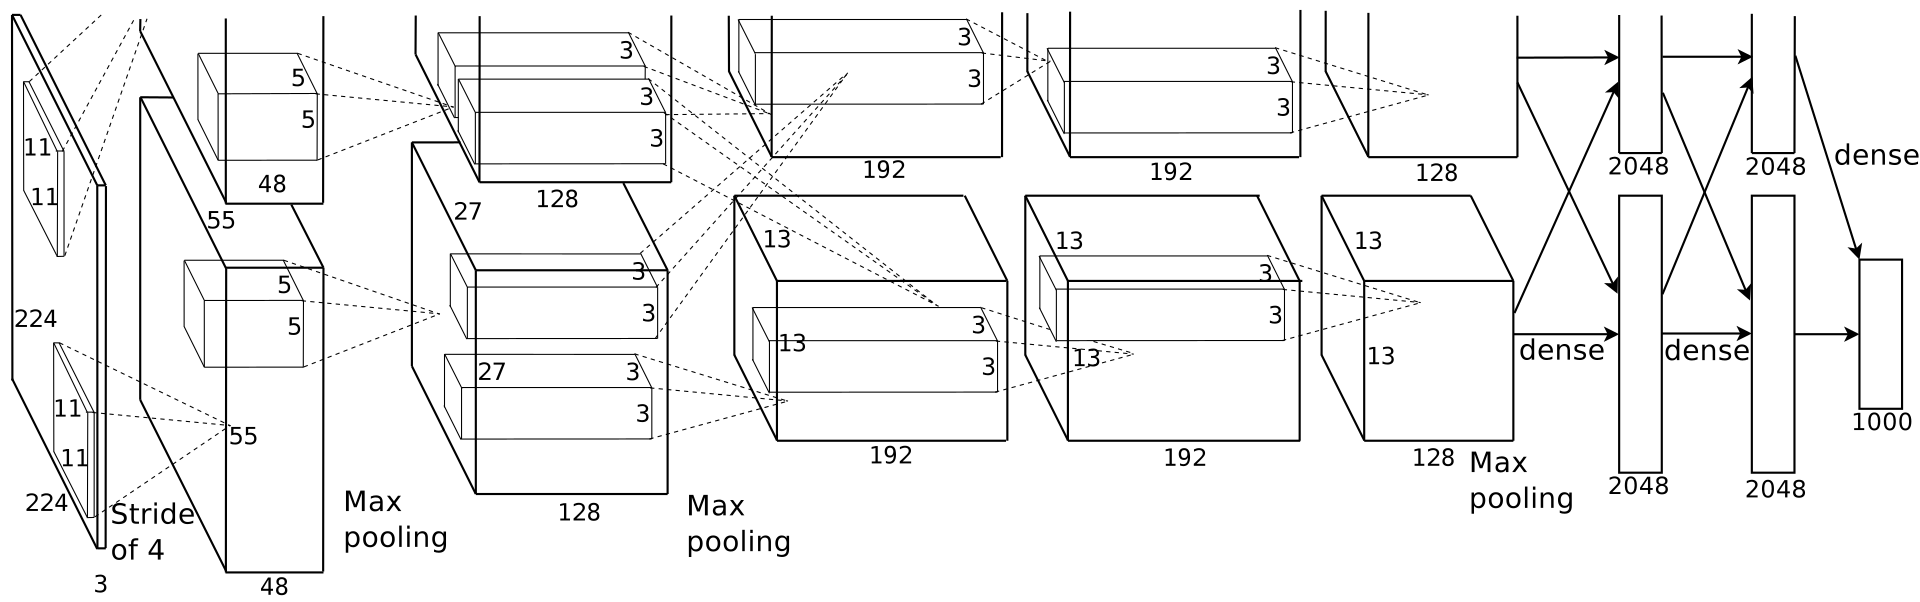

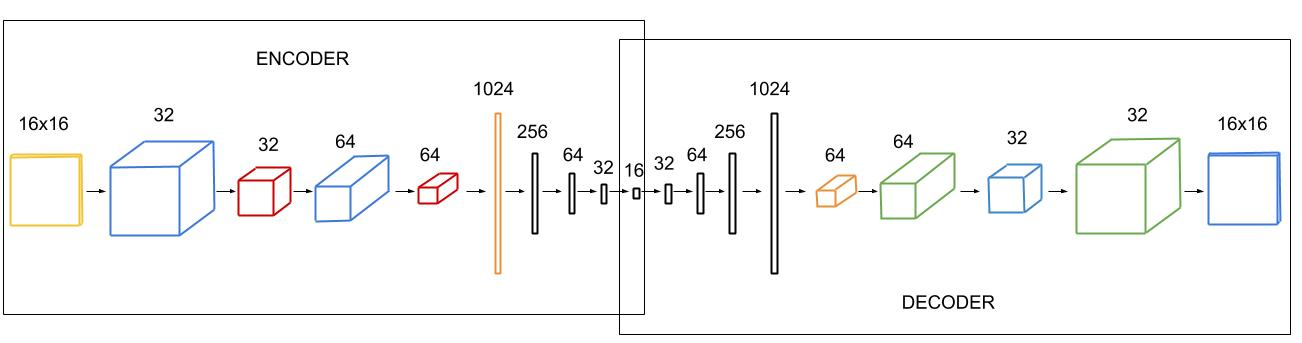

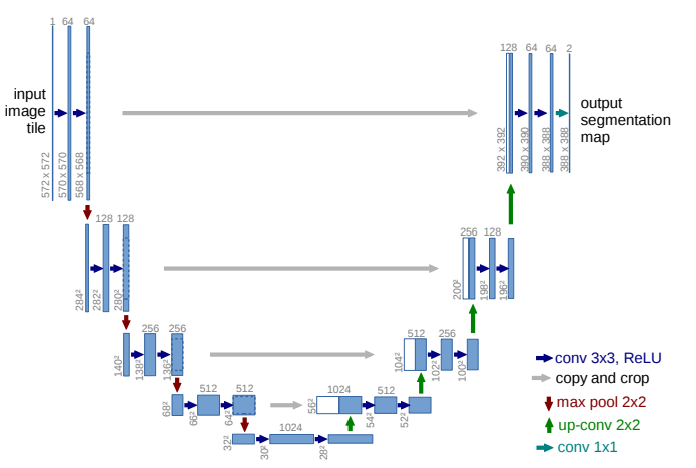

Los tres son casos de redes *Feedforward*, pero lo interesante de estos esquemas es... que ahí no aparecen neuronas. Esos grafos muestran la relación entre *capas* de neuronas. En la práctica en Aprendizaje Profundo el diseño de las redes no se hace pensando en neuronas particulares, sino en capas. En palabras de François Chollet (creador de Keras y uno de los principales investigadores de Google durante 10 años): *The fundamental data structure in neural networks is the layer*. Y él mismo las denomina *the building blocks of deep learning*.

Podríamos afirmar que una capa es una abstracción sobre las neuronas, así que formalmente podríamos decir que son una lista de funciones (porque cada neurona recordemos que es una función).

l = [f<sub>1</sub>, f<sub>2</sub>, ..., f<sub>n</sub>]

Lo importante es que todas esas funciones son neuronas que por convención son del mismo tipo y comparten datos de entrada. De esa manera, podemos hablar de una capa de neuronas lineales, una capa de neuronas convolucionales, etc.

Un ejemplo claro es un Perceptrón Multicapa.


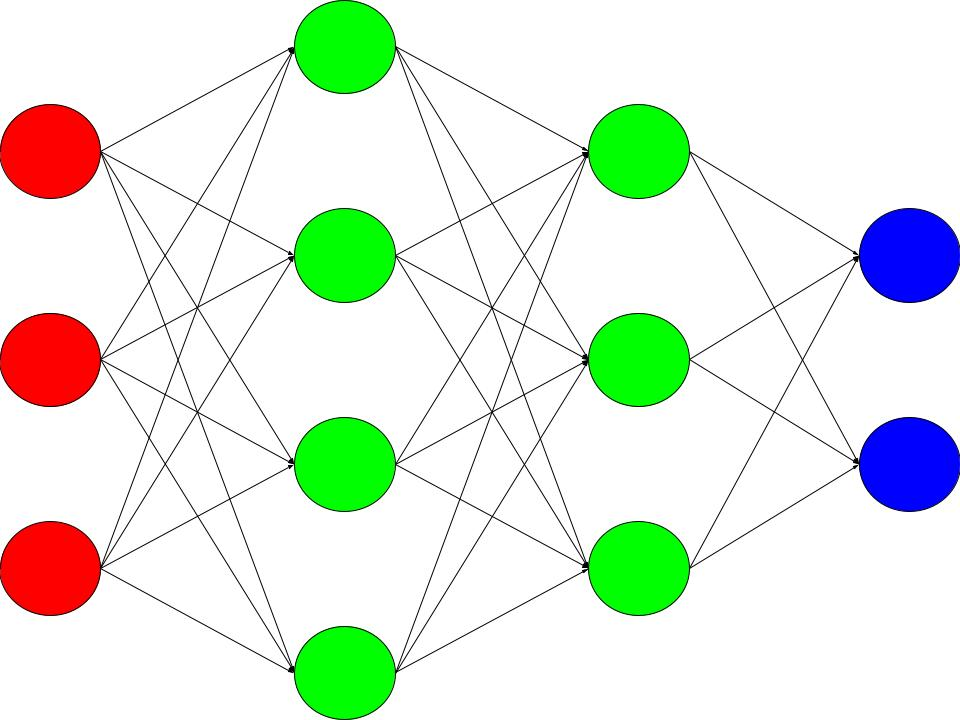

Ese dibujo representa explícitamente las neuronas, pero en la práctica uno lo interpretaría como: 3 datos de entrada (círculos rojos a veces denóminados engañosamente capa de entrada), una capa de 4 neuronas densas, otra capa de 3 neuronas densas (los círculos verdes) y una capa final con 2 neuronas densas que sirven como salida. Por convención en los Perceptrones Multicapa se diferencia entre la capa de entrada, las capas ocultas y la capa de salida. Esto, como digo, es mera convención porque en el perceptrón todas las neuronas (círculos verdes y azules) son neuronas clásicas (o lineales o densas, como las queramos llamar). Si se suele hablar de capas densas es porque al añadir una capa de neuronas de ese tipo se asume que todas las neuronas de la capa están conectadas con todas las salidas de la capa anterior. Antes me he referido como engañoso al hablar de la capa de entrada porque realmente no representan funciones, sino los datos de entrada. Aún así, la convención llama a los datos de entrada capa de entrada y en algunos Frameworks como Tensorflow hay que indicar explícitamente una capa de entrada de datos al montar la red.

¿Por qué hablamos de capas en realidad? ¡Porque en cada una ponemos muchísimas neuronas como para hacer grafos mostrándolas! En los esquemas anteriores podemos ver representadas las capas densas al final de la Alexnet y en el centro del autoencoder como rectángulos verticales (reflejando esa idea intuitiva de que son una fila de neuronas colocadas verticalmente heredada de los MLPs clásicos) junto a la cifra que indica cuántas neuronas tiene esa capa. Con esa facilidad indicamos que se han añadido miles de neuronas...

Según convenga uno hace la distinción a nivel de neurona, a nivel de capa, a nivel de bloque de capas (eso es raro) o a nivel de todo el modelo.

Ahora que tenemos la noción de capa vamos a volver a PyTorch y a ver cómo se puede montar una red neuronal.

Antes, por pura comodidad vamos a crear una función que sea nuestro bucle de entrenamiento.

In [17]:
def learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer):
  loss_list = []

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  for step in range(steps):
    y_pred = model(x_true)                              # Forward
    opt.zero_grad()
    loss = loss_fn(y_pred, y_true)
    loss.backward()                                     # Backward
    #print(f"--------- step {step}")
    #print(f"Parametros actuales actual: {[param for param in model.parameters()]}")
    #print(f"Valor medio de y: {y_true.mean()}")
    #print(f"Valor medio de y predicho: {y_pred.mean()}")
    #print(f"Error: {loss}")
    loss_list.append(loss.clone().detach())
    #print(f"Gradiente: {[param.grad for param in model.parameters()]}")
    opt.step()

  return model, loss_list

Comos e puede ver, hemos omitido o comentado la referencia a los parámetros concretos. De ahora en adelante vamos a asumir que son demasiados como para atender a ningún parámetro en particular. Sí que llevamos el registro del valor de error. ¿Por qué? Para tener una noción de cómo avanza el entrenamiento.

Ahora vamos a intentar ajustar un modelo neuronal con dos capas a la dichosa función y=x<sup>2</sup>. Vamos a empezar probando con dos capas de una única neurona cada una. La primera capa tendrá de activación la tangente hiperbólica, mientras que a la segunda no le vamos a poner ninguna activación.

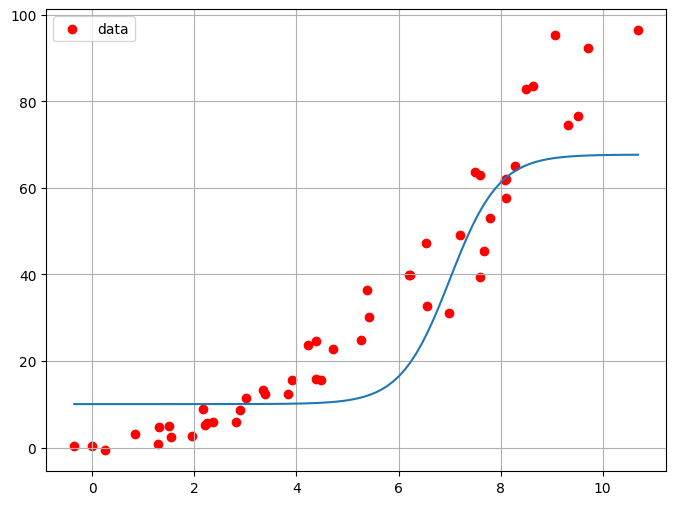

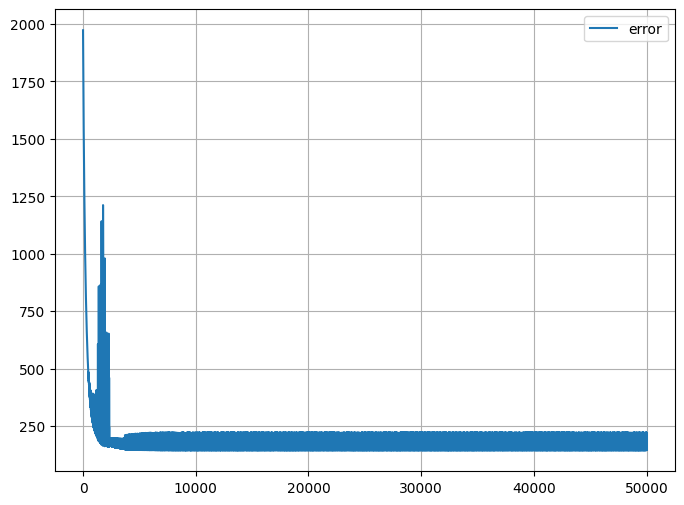

In [19]:
polynomial_cofficients = [1,0,0]
polynomial = generate_polynomial(polynomial_cofficients)
data = get_data_from_a_polynomial(polynomial, 50, sigma=0.5, range=10)

learning_rate = 1e-3
steps = 50000
loss_fn = torch.nn.MSELoss()

model = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Tanh(),
    torch.nn.Linear(1,1),
)

optimizer = torch.optim.SGD

x_true = data[:,0][:,None]
y_true = data[:,1][:,None]

model, loss_list = learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer)

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(steps), loss_list, label="error")
plt.legend()
plt.grid(True)
plt.show()

Eso básicamente es la forma de la tangente hiperbólica trasladada y reescalada por la segunda capa para intentar minimizar el error, pero no es suficiente. Veamos con dos neuronas en la primera capa.

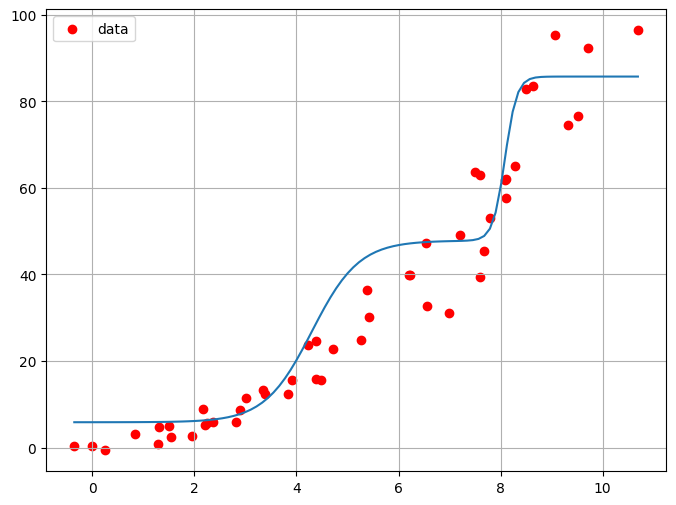

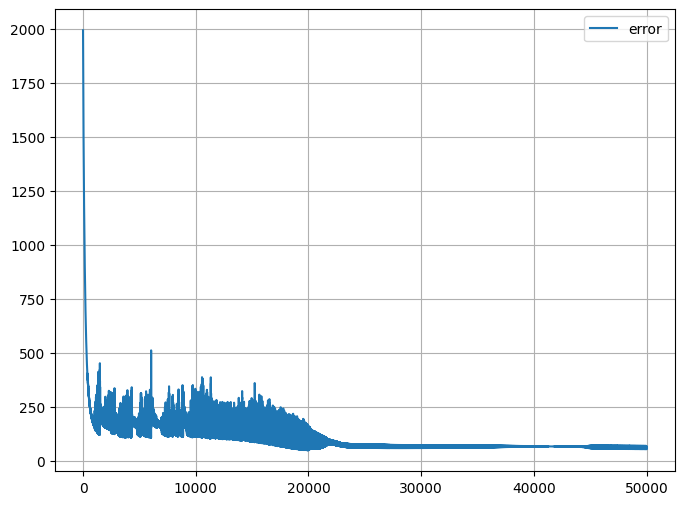

In [20]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.Tanh(),
    torch.nn.Linear(2,1),
)

model, loss_list = learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer)

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(steps), loss_list, label="error")
plt.legend()
plt.grid(True)
plt.show()

Mejor, pero parece que aún el modelo no tiene potencia suficiente para adquirir la forma que queremos. 3 neuronas en la primera capa:

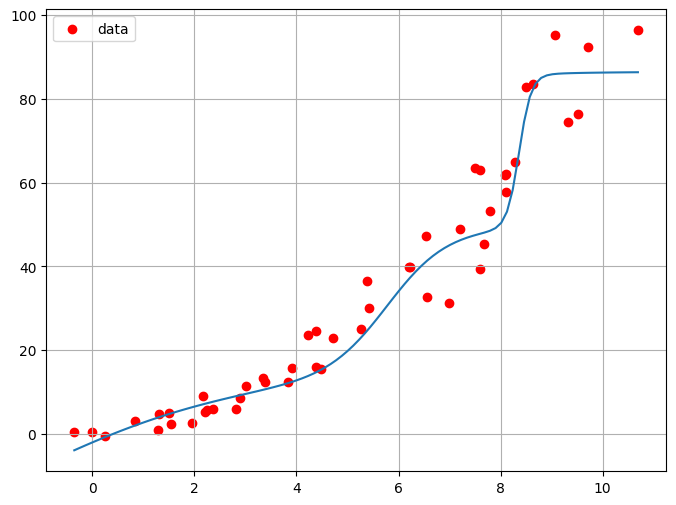

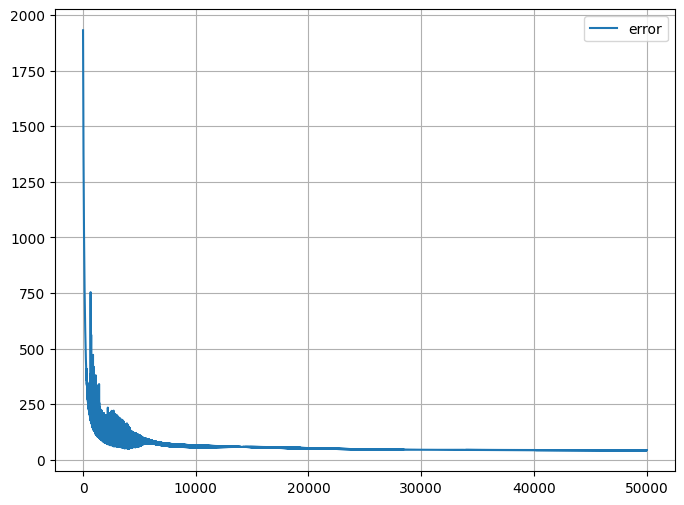

In [21]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,3),
    torch.nn.Tanh(),
    torch.nn.Linear(3,1),
)

model, loss_list = learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer)

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(steps), loss_list, label="error")
plt.legend()
plt.grid(True)
plt.show()

¿Y con 5?

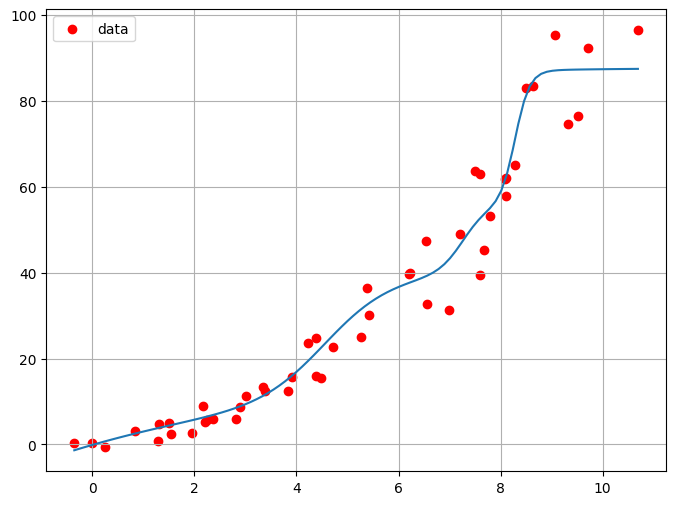

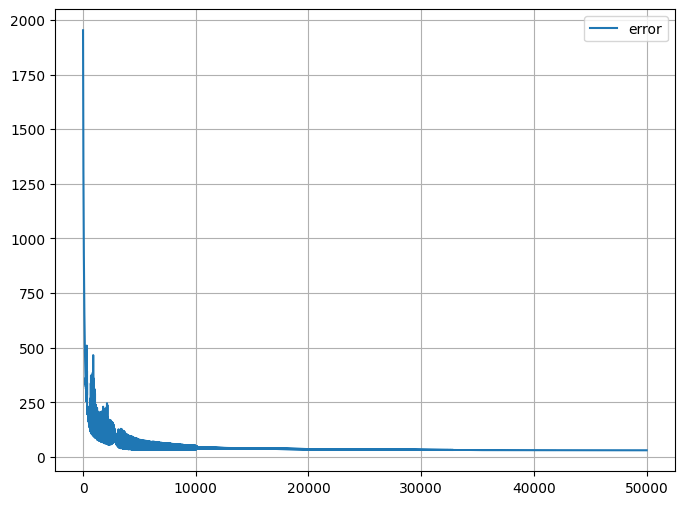

In [22]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,5),
    torch.nn.Tanh(),
    torch.nn.Linear(5,1),
)

model, loss_list = learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer)

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(steps), loss_list, label="error")
plt.legend()
plt.grid(True)
plt.show()

Parece que vamos mejorando...

Comos e puede ver, para definir el modelo estamos usando la clase torch.nn.Sequential(). No es la única manera de definir un modelo neuronal que permite PYTorch, pero es una rápida y flexible. Como rgumento se le indica la lista de capas (y funciones de activación) que queremos y ya tenemos un modelo listo para ser entrenado.

Las capas, en este caso Lineales, se deben interpretar de la siguiente manera: torch.nn.Lineal(1,5) indica que es una capa de neuronas lineales que tiene una entrada y 5 salidas. Cada salida va a ser una neurona, así que es una capa con cinco neuronas ya que obtendremos una salida distinta por neurona. Las capas de otros tipos de neuronas se definen de maneras distintas según el tipo de neurona.

Vamos a venirnos arriba. Añadamos otra capa más de 5 neuronas también con activación tangente hiperbólica.

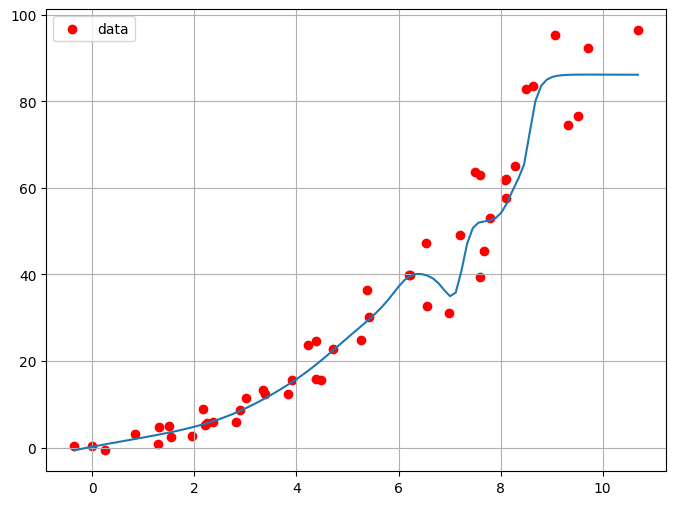

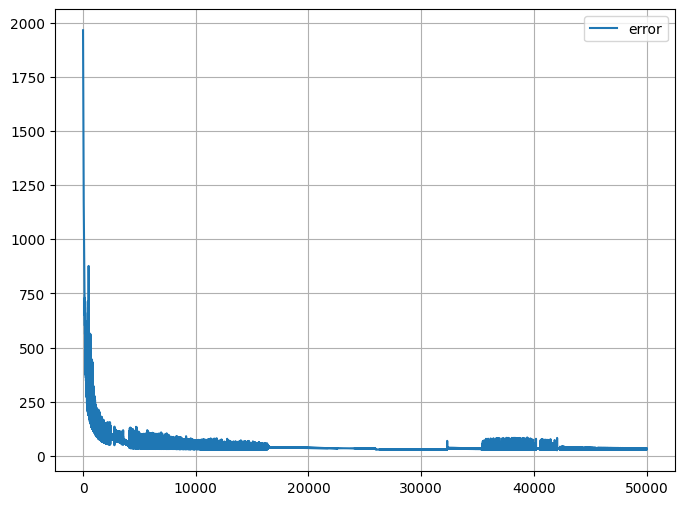

In [27]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,5),
    torch.nn.Tanh(),
    torch.nn.Linear(5,5),
    torch.nn.Tanh(),
    torch.nn.Linear(5,1),
)

model, loss_list = learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer)

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(steps), loss_list, label="error")
plt.legend()
plt.grid(True)
plt.show()

Venga, otra capa más.

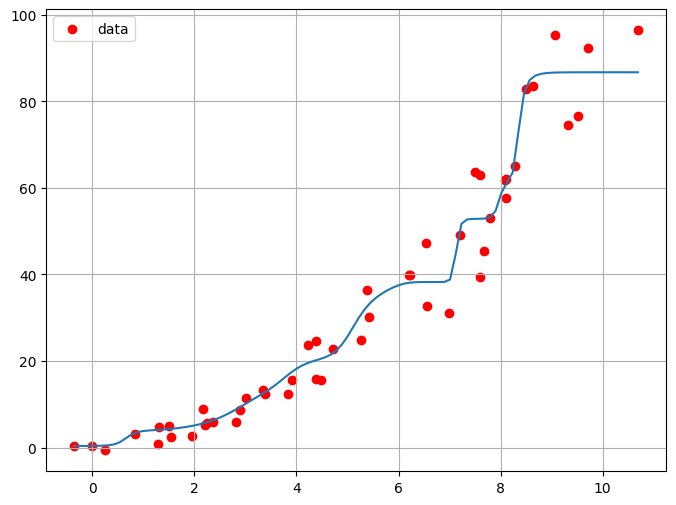

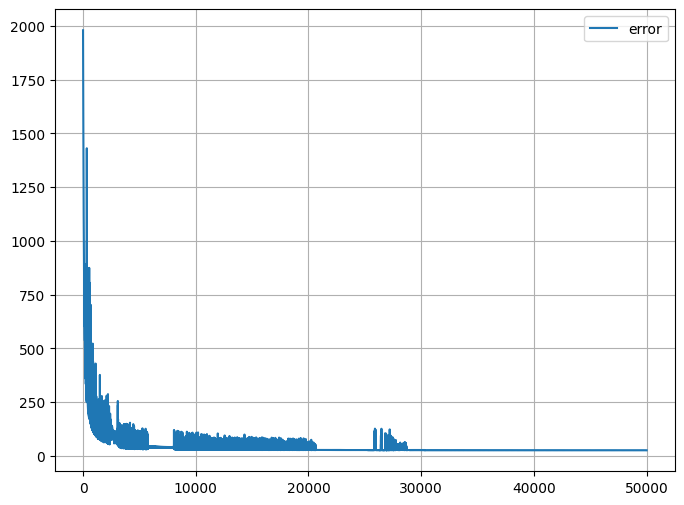

In [28]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,5),
    torch.nn.Tanh(),
    torch.nn.Linear(5,5),
    torch.nn.Tanh(),
    torch.nn.Linear(5,5),
    torch.nn.Tanh(),
    torch.nn.Linear(5,1),
)

model, loss_list = learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer)

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(steps), loss_list, label="error")
plt.legend()
plt.grid(True)
plt.show()

Vamos a probar cambiando las funciones de activación por las ReLU.

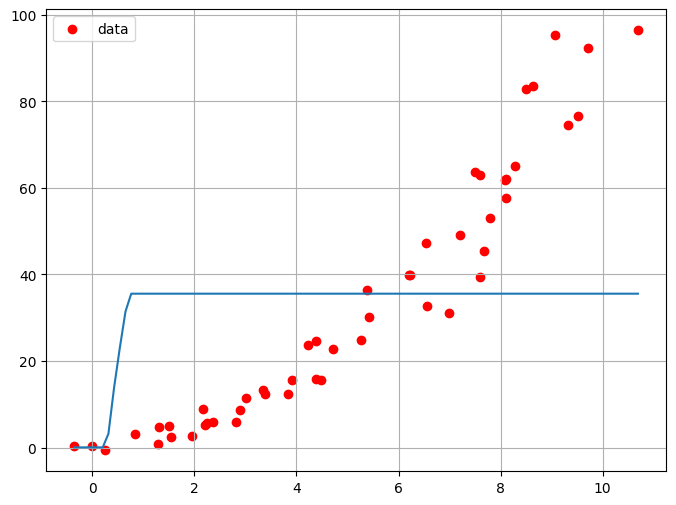

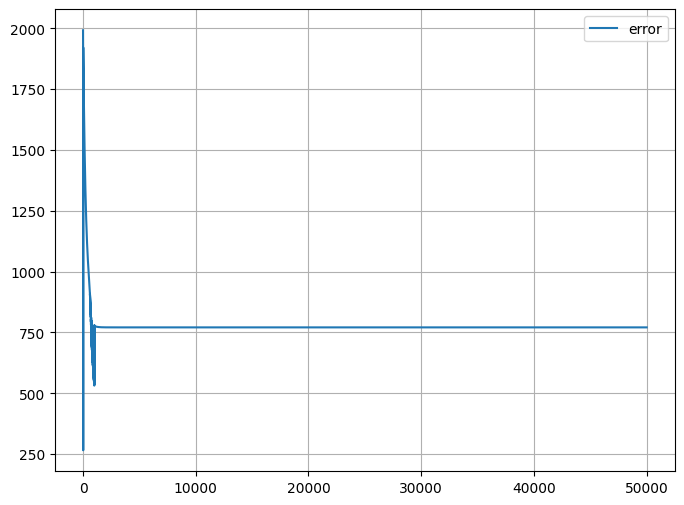

In [32]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,5),
    torch.nn.ReLU(),
    torch.nn.Linear(5,5),
    torch.nn.ReLU(),
    torch.nn.Linear(5,5),
    torch.nn.ReLU(),
    torch.nn.Linear(5,1),
)

model, loss_list = learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer)

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(steps), loss_list, label="error")
plt.legend()
plt.grid(True)
plt.show()

Qué resultados más raros... ¡Vamos a echar un vistazo al gradiente que se obtiene!

In [35]:
loss = torch.nn.MSELoss()(model(x_true), y_true)
loss.backward()
print([param.grad for param in model.parameters()])

[tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]), tensor([0., 0., 0., 0., 0.]), tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]), tensor([0., 0., 0., 0., 0.]), tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]), tensor([-0.0004,  0.0000,  0.0000,  0.0000, -0.0004]), tensor([[0.0004, 0.0000, 0.0000, 0.0000, 0.0003]]), tensor([-0.0057])]


UPS. Parece que hemos perdido el gradiente. Probablemente los valores han entrado en la zona no sensible de la función de activación. ¡Veamos si cambiamos por LeakyReLU!

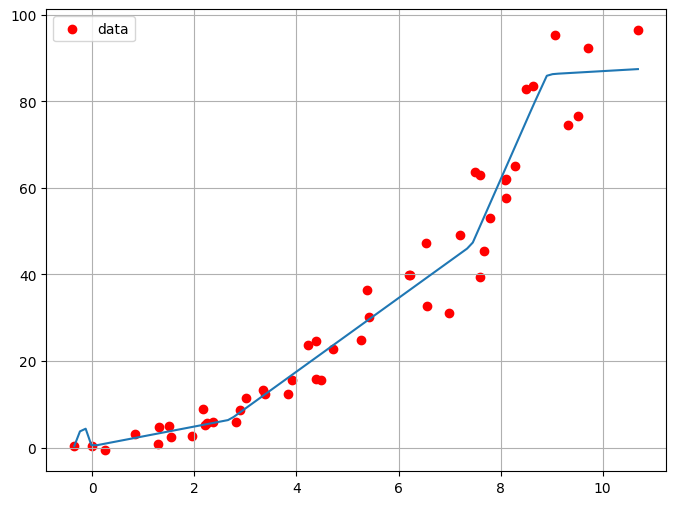

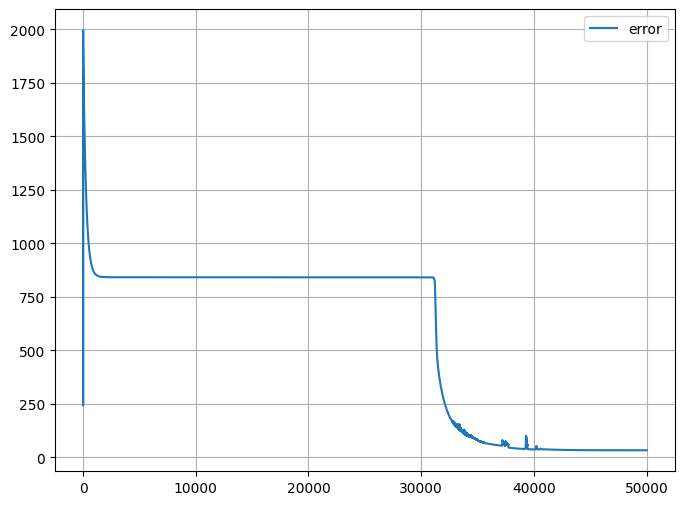

In [36]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5,5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5,5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5,1),
)

model, loss_list = learning_loop(x_true, y_true, model, steps, loss_fn, learning_rate, optimizer)

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(steps), loss_list, label="error")
plt.legend()
plt.grid(True)
plt.show()

Parece que no somos capaces de obtener una curva bonita como la función y=x<sup>2</sup>. Vaya decepción, ¿no? Aunque en honor a la verdad, estamos consiguiendo aproximaciones a los datos que parecen razonables. Simplemente no son la función de la que nosotros sabemos que vienen los datos, ¡pero es que normalmente nos abemos la función de origen! Una aproximación razonable es lo máximo que podemos conseguir...

Supongo que la siguiente pregunta es... ¿Cómo se diseña una red neuronal? ¿Cómo decidimos cuántas capas? ¿Cuántas neuronas por capa? ¿Qué función de activación en cada capa? Lo cierto es... que no hay ningún método. El Teorema de Aproximación Universal de 1989 demuestra que un MLP con al menos una capa oculta con una función de activación como las que hemos visto y una salida lineal debería ser capaz de aproximar cualquier función. Lo que no dice el Teorema es cuántas neuronas necesita esa capa oculta ni cómo entrenar ese hipotético MLP. Solo dice que existe la solución, pero ni cuál es ni cómo alcanzarla. Para el diseño uno se tiene que guiar por la prueba y error, su experiencia, su conocimiento de problemas similares y su intuición matemática.

¿Ponemos entonces una sola capa oculta en los MLPs y atacamos con eso todos los problemas? No. Aunque el teorema dice que existe esa solución, en muchos casos una capa oculta con muchísimas neuronas lineales no es fácil o rápido de entrenar y varias capas más pequeñas (o el uso de otras neuronas) permiten entrenamientos más estables que converjan a una solución. El número de neuronas de la última capa sí es fácil de deducir. Si quiero solo un valor como resultado, será una, si quiero mil valores, serán mil.

Respecto a las funciones de activación, hay que tener en mente que juegan dos papeles:

*   En las capas internas de un modelo sirven para transformar los datos. Ahí no hay un criterio general sobre cómo elegir función de activación, aunque la práctica experimental nos dice que funciones como la ReLU y la LeakyReLU **suelen** funcionar mejor que usar la tangente hiperbólica o la sigmoide.
*   En la última capa la elección de la función de activación viene restringido por el problema que estoy resolviendo. Si quiero un resultado entre dos opciones (por ejemplo para un problema de clasificación binaria) usaré una función sigmoide o una tangente hiperbólica. Si quiero resolver un problema de regresión general tendré que usar una cuyo codominio permita todos los reales como la LeakyReLU o (como hacíamos aquí) dejar la última capa sin activación específica y permitir que se comporte como una función lineal. Si el resultado es un número positivo cualquiera podríamos usar la ReLU.

